In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import time
import xgboost as xgb
import lightgbm as lgb
# import category_encoders as cat_ed
import gc, mlcrate, glob

# from gplearn.genetic import SymbolicTransformer, SymbolicClassifier
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from IPython.display import display

from catboost import CatBoostClassifier
from scipy.cluster import hierarchy as hc
from collections import Counter

from sklearn import metrics
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [3]:
PATH = os.getcwd()
PATH

'D:\\Github\\fastai\\courses\\ml1\\AV_WNS'

In [4]:
df_raw = pd.read_csv(f'{PATH}\\train.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}\\test.csv', low_memory=False)

df_raw['previous_year_rating'].fillna(0, inplace=True)
df_test['previous_year_rating'].fillna(0, inplace=True)

df_raw['education'].replace('\'s', '', regex=True, inplace=True)
df_test['education'].replace('\'s', '', regex=True, inplace=True)

df_raw.drop('employee_id', axis=1, inplace=True)
df_test.drop('employee_id', axis=1, inplace=True)

In [5]:
for c in df_raw.columns:
    n = df_raw[c].nunique()
    print(c)
    if n <= 8:
        print(n, sorted(df_raw[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(120 * '-')

department
9
------------------------------------------------------------------------------------------------------------------------
region
34
------------------------------------------------------------------------------------------------------------------------
education
3 [('Bachelor', 36669), ('Below Secondary', 805), ('Master & above', 14925)]
------------------------------------------------------------------------------------------------------------------------
gender
2 [('f', 16312), ('m', 38496)]
------------------------------------------------------------------------------------------------------------------------
recruitment_channel
3 [('other', 30446), ('referred', 1142), ('sourcing', 23220)]
------------------------------------------------------------------------------------------------------------------------
no_of_trainings
10
------------------------------------------------------------------------------------------------------------------------
age
41
------------------

In [6]:
df_raw.shape, df_test.shape

((54808, 13), (23490, 12))

In [7]:
new_cols = ['department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met_more_than_80_percent', 'awards_won_bool',
       'avg_training_score', 'is_promoted']
#re-naming them
df_raw.columns = new_cols
df_test.columns = new_cols[:-1]

cat_cols = list(df_raw.select_dtypes(include=['object']).columns)
num_cols = list(df_raw.select_dtypes(exclude=['object']).columns)

In [8]:
df_raw_cat, df_test_cat = df_raw[cat_cols], df_test[cat_cols]

In [9]:
df_raw.get_ftype_counts()

object:dense     5
int64:dense      7
float64:dense    1
dtype: int64

In [10]:
bins = [0., 5., 10., 15., 20., 25., 30., 35., 40]
labels = [i+1 for i in range(len(bins) - 1)]
bin_cols = ['length_of_service']
for col in bin_cols:    
    df_raw[f'bin_{col}'.format(col)]  = pd.cut(df_raw[col] , bins, labels = labels)
    df_test[f'bin_{col}'.format(col)] = pd.cut(df_test[col], bins, labels = labels)

bins = [10, 20., 25., 30., 35., 40., 45., 50., 55., 60., 70]
labels = [i+1 for i in range(len(bins) - 1)]
bin_cols = ['age']
for col in bin_cols:    
    df_raw[f'bin_{col}'.format(col)]  = pd.cut(df_raw[col] ,bins,labels = labels)
    df_test[f'bin_{col}'.format(col)] = pd.cut(df_test[col],bins,labels = labels)

bins = [30, 39., 44., 54., 66., 75., 80., 85., 90., 100]
labels = [i+1 for i in range(len(bins) - 1)]
bin_cols = ['avg_training_score']
for col in bin_cols:    
    df_raw[f'bin_{col}'.format(col)]  = pd.cut(df_raw[col] ,bins,labels = labels)
    df_test[f'bin_{col}'.format(col)] = pd.cut(df_test[col],bins,labels = labels)

df_raw['promotion_chance'] = 'low'
my_query = df_raw.query('avg_training_score>=90').index
df_raw.iloc[my_query, -1] = 'very_high'
my_query = df_raw.query('avg_training_score>=75 and avg_training_score<90').index
df_raw.iloc[my_query, -1] = 'high'
my_query = df_raw.query('avg_training_score>=65 and avg_training_score<75').index
df_raw.iloc[my_query, -1] = 'medium'
my_query = df_raw.query('avg_training_score>=53 and avg_training_score<65').index
df_raw.iloc[my_query, -1] = 'low_medium'

df_test['promotion_chance'] = 'low'
my_query = df_test.query('avg_training_score>=90').index
df_test.iloc[my_query, -1] = 'very_high'
my_query = df_test.query('avg_training_score>=75 and avg_training_score<90').index
df_test.iloc[my_query, -1] = 'high'
my_query = df_test.query('avg_training_score>=65 and avg_training_score<75').index
df_test.iloc[my_query, -1] = 'medium'
my_query = df_test.query('avg_training_score>=53 and avg_training_score<65').index
df_test.iloc[my_query, -1] = 'low_medium'

#######################################################################################

df_raw['new_employee'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('previous_year_rating == 0').index
df_raw.iloc[my_query, -1] = 1

df_test['new_employee'] = np.zeros(df_test.shape[0])
my_query = df_test.query('previous_year_rating == 0').index
df_test.iloc[my_query, -1] = 1

df_raw['joining_age'] = df_raw['age'] - df_raw['length_of_service']
df_test['joining_age'] = df_test['age'] - df_test['length_of_service']

df_raw['main_training_received_for_promo'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('no_of_trainings <=2').index
df_raw.iloc[my_query, -1] = 1

df_test['main_training_received_for_promo'] = np.zeros(df_test.shape[0])
my_query = df_test.query('no_of_trainings <=2').index
df_test.iloc[my_query, -1] = 1

df_raw['region'].replace('region_', '', True, None, True)
df_test['region'].replace('region_', '', True, None, True)

df_raw['major_promo_region'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('region == \'2\' or region == \'22\' or region ==\'7\' or region == \'4\' or region == \'13\' or region ==\'15\'').index
df_raw.iloc[my_query, -1] = 1

df_test['major_promo_region'] = np.zeros(df_test.shape[0])
my_query = df_test.query('region == \'2\' or region == \'22\' or region ==\'7\' or region == \'4\' or region == \'13\' or region ==\'15\'').index
df_test.iloc[my_query, -1] = 1

df_raw['trainings_less_2'] = np.zeros(df_raw.shape[0])
my_query = df_raw.query('no_of_trainings <=2').index
df_raw.iloc[my_query, -1] = 1

df_test['trainings_less_2'] = np.zeros(df_test.shape[0])
my_query = df_test.query('no_of_trainings <=2').index
df_test.iloc[my_query, -1] = 1

def map_(regs, age):
    d = {}
    for i,j in zip(regs, age):
        d[i] = j
    return d

xyz = df_raw.groupby('region').mean().sort_values(by='region')[['age', 'joining_age', 'previous_year_rating', 'length_of_service', 'avg_training_score']]
count = Counter(df_raw['region'])

regs                   = xyz.reset_index()['region'].values
age                    = xyz.reset_index()['age'].values
joining_age            = xyz.reset_index()['joining_age'].values
previous_year_rating   = xyz.reset_index()['previous_year_rating'].values
length_of_service      = xyz.reset_index()['length_of_service'].values 
avg_training_score     = xyz.reset_index()['avg_training_score'].values

df_raw['reg_count'] = df_raw['region'].map(count)
d = map_(regs, age)
df_raw['mean_age_per_region']   = df_raw['region'].map(d)
d = map_(regs, joining_age)
df_raw['mean_joining_age_per_region']   = df_raw['region'].map(d)
d = map_(regs, previous_year_rating)
df_raw['mean_previous_year_rating_per_region']   = df_raw['region'].map(d)
d = map_(regs, avg_training_score)
df_raw['mean_avg_training_score_per_region']   = df_raw['region'].map(d)
d = map_(regs, length_of_service)
df_raw['mean_length_of_service_per_region']   = df_raw['region'].map(d)

xyz = df_test.groupby('region').mean().sort_values(by='region')[['age', 'joining_age', 'previous_year_rating', 'length_of_service', 'avg_training_score']]
count = Counter(df_test['region'])

regs                   = xyz.reset_index()['region'].values
age                    = xyz.reset_index()['age'].values
joining_age            = xyz.reset_index()['joining_age'].values
previous_year_rating   = xyz.reset_index()['previous_year_rating'].values
length_of_service      = xyz.reset_index()['length_of_service'].values 
avg_training_score     = xyz.reset_index()['avg_training_score'].values

df_test['reg_count'] = df_test['region'].map(count)
d = map_(regs, age)
df_test['mean_age_per_region']   = df_test['region'].map(d)
d = map_(regs, joining_age)
df_test['mean_joining_age_per_region']   = df_test['region'].map(d)
d = map_(regs, previous_year_rating)
df_test['mean_previous_year_rating_per_region']   = df_test['region'].map(d)
d = map_(regs, avg_training_score)
df_test['mean_avg_training_score_per_region']   = df_test['region'].map(d)
d = map_(regs, length_of_service)
df_test['mean_length_of_service_per_region']   = df_test['region'].map(d)
####################################################################################

del d, count, regs, joining_age, previous_year_rating, length_of_service, avg_training_score
gc.collect()

244

In [11]:
df_raw.shape, df_test.shape

((54808, 28), (23490, 27))

In [12]:
df_raw.drop(cat_cols, axis=1, inplace=True)
df_test.drop(cat_cols, axis=1, inplace=True)

In [13]:
df_raw_cat['dept_rec'] = 'in ' + df_raw_cat['department'] + ' via ' + df_raw_cat['recruitment_channel']
df_test_cat['dept_rec'] = 'in ' + df_test_cat['department'] + ' via ' + df_test_cat['recruitment_channel']

df_raw_cat['gen_edu'] =  df_raw_cat['gender'] + ' has ' + df_raw_cat['education']
df_test_cat['gen_edu'] = df_test_cat['gender'] + ' has ' + df_test_cat['education']

In [14]:
idx_split = df_raw_cat.shape[0]
df_raw_cat.head(1)

,department,region,education,gender,recruitment_channel,dept_rec,gen_edu
0,Sales & Marketing,region_7,Master & above,f,sourcing,in Sales & Marketing via sourcing,f has Master & above


In [15]:
target = df_raw.is_promoted

In [16]:
full_df = pd.concat((df_raw_cat, df_test_cat), axis = 0, ignore_index=True)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
full_sites = full_df[:].astype('str')
lst = full_sites.as_matrix().tolist()
flat_list = [' '.join(sublist) for sublist in lst]
vect = TfidfVectorizer(ngram_range=(1,2), max_features=500,analyzer='char_wb')
tfidf_matrix = vect.fit_transform(flat_list)

X_train_tf = tfidf_matrix[:idx_split]
X_test_tf  = tfidf_matrix[idx_split:]

X_train_tf.shape, X_test_tf.shape

((54808, 194), (23490, 194))

In [18]:
%%time
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=120)
svd.fit(X_train_tf)
X_train_svd = svd.transform(X_train_tf)
X_test_svd = svd.transform(X_test_tf)
# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_test_svd_scl = scl.transform(X_test_svd)

Wall time: 5.59 s


In [36]:
train_cats(df_raw);
apply_cats(df_test, df_raw);

In [23]:
cat_cols = list(df_raw.select_dtypes(include=['category', 'object']).columns)
num_cols = list(df_raw.select_dtypes(exclude=['object', 'category']).columns)

In [28]:
train_dummies = pd.get_dummies(pd.concat((df_raw_cat,df_raw[cat_cols]),axis=1), drop_first=True)
test_dummies = pd.get_dummies(pd.concat((df_test_cat,df_test[cat_cols]),axis=1), drop_first=True)
#df_raw.drop(cat_cols, axis=1, inplace=True)
#df_test.drop(cat_cols), axis=1, inplace=True)
df_raw.shape, df_test.shape, train_dummies.shape, test_dummies.shape

((54808, 23), (23490, 22), (54808, 105), (23490, 105))

In [29]:
# df_raw.drop(cat_cols, axis=1, inplace=True)
# df_test.drop(cat_cols, axis=1, inplace=True)

In [36]:
X_train_tf.shape, df_raw.shape, train_dummies.shape

((54808, 194), (54808, 18), (54808, 105))

In [40]:
X_test_tf.shape, df_test.shape, test_dummies.shape

((23490, 194), (23490, 18), (23490, 105))

In [53]:
train_all, test_all = np.hstack([df_raw.values, train_dummies.values, X_train_tf.todense()]),np.hstack([df_test.values, test_dummies.values, X_test_tf.todense()])
train_all.shape, test_all.shape

((54808, 317), (23490, 317))

In [65]:
train_all, test_all = pd.concat([df_raw, train_dummies], axis=1), pd.concat([df_test, test_dummies], axis=1)

In [102]:
train_all, target, test_all = np.save('train_all_better.npy', train_all), np.save('target.npy',target), np.save('test_all_better.npy',test_all)

In [4]:
train_all, target, test_all = np.load('train_all_better.npy'), np.load('target.npy'), np.load('test_all_better.npy')

In [5]:
def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\sample_submission.csv')
    submit = sample.copy()
    submit['is_promoted'] = probs
    return submit

In [6]:
np.count_nonzero(target), target.shape[0]- 4668

(4668, 50140)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train_all, target, test_size = .2, stratify = target)

In [8]:
%%time
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, auc, f1_score
clf_lr = LogisticRegression (random_state = 42,n_jobs=-1,max_iter=1000)
clf_lr.fit (X_train, y_train)
preds_lr = clf_lr.predict_proba (X_valid) [:, 1]
print ('Train test split LogisticRegression score:% s ROC AUC'% round (roc_auc_score (y_valid, preds_lr), 4))
print('F1 Score', f1_score(y_valid, (preds_lr>.61)*1))
print('F1 Score', f1_score(y_valid, (preds_lr>.7)*1))

Train test split LogisticRegression score:0.8535 ROC AUC
F1 Score 0.294964028777
F1 Score 0.267281105991
Wall time: 4.3 s


In [22]:
def show_confusion_matrix ( y_true ,  y_pred ,  title  =  'Confusion matrix' ): 
    table = confusion_matrix ( y_true ,  y_pred )#.values maybe
    fig , ax  =  plt . subplots ( frameon = False ) 
    fig.set_size_inches ( 4 ,  3 ) 
    fig.suptitle (title ,  fontsize  =  20 ) 
    ax.axis( 'off' ) 
    ax.xaxis.set_visible ( False )  
    ax.yaxis.set_visible ( False )
    the_table  =  ax . table ( cellText = table , 
        colWidths = [ 0.5 ] * len ([ 0 ,  1 ]), 
        rowLabels = ['True 0','True 1'],colLabels = [ 'Predicted 0' ,  'Predicted 1' ], 
        cellLoc='center',rowLoc='center',loc="center")
    the_table.set_fontsize(34) 
    the_table.scale(1,4) 

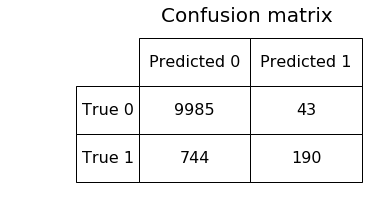

In [23]:
show_confusion_matrix(y_valid, clf_lr.predict( X_valid ))

In [27]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.8):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed,max_iter=8000,n_jobs=-1, class_weight='balanced').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict(X[idx:, :])
    # Calculate the quality
    score = f1_score(y[idx:], y_pred)
    return score

In [28]:
%%time
from tqdm import tqdm_notebook
# List of possible C-values
Cs = np.logspace(-1, 3, 20)

scores = []

for C in tqdm_notebook(Cs):
     scores.append(get_auc_lr_valid(X_train, y_train, C=C))

A Jupyter Widget


Wall time: 2min 42s


In [29]:
max(scores), Cs[np.argmax(scores)]

(0.37186839722306064, 12.742749857031335)

F1 on the test sample: 0.409 


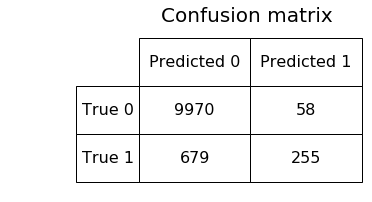

In [30]:
final_model = LogisticRegression(random_state = 17,max_iter=8000, C = Cs[np.argmax(scores)],n_jobs=-1) 
final_model.fit(X_train,y_train) 
print('F1 on the test sample: {} '.format(round(f1_score(y_valid,final_model.predict(X_valid)),4))) 
show_confusion_matrix(y_valid, final_model.predict(X_valid))

In [8]:
def runXGB(train_X, train_y, test_X, test_y=None):
        params = {}
        params['booster'] = 'gbtree'
        params['tree_method'] = 'gpu_hist'
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'aucpr'
        params["eta"] = 0.05 #0.03
        params["subsample"] = .8
        params["silent"] = 0
        params['verbose'] = 2
        params["max_depth"] = 9
        params["seed"] = 1
        params["max_delta_step"] = 4
        params['scale_pos_weight'] =  50140/4668
        params["gamma"] = 0.6 #.5 #.1 #.2
        params['colsample_bytree'] = 0.75
        nrounds = 700 #3600 #2000 #4000
        plst = list(params.items())

        xgtrain = xgb.DMatrix(train_X, label=train_y)
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, nrounds)
        pred_test_y = model.predict(xgtest)
        return pred_test_y

In [81]:
val_preds = runXGB(X_train, y_train, X_valid,)

In [82]:
val_preds, max(val_preds)

(array([ 0.18268,  0.00008,  0.54749, ...,  0.00009,  0.07348,  0.00283], dtype=float32),
 0.99999917)

In [36]:
params = {}
params['booster'] = 'gbtree'
#params['tree_method'] = 'gpu_hist'
params["objective"] = "binary:logistic"
params['eval_metric'] = 'auc'
params["eta"] = 0.05
params["subsample"] = .7
params["silent"] = 0
params['verbose'] = 1
params["max_depth"] = 9
params["seed"] = 1
params["max_delta_step"] = 4
params['scale_pos_weight'] =  50140/4668
params["gamma"] = 1. #.5 #.1 #.2
params['colsample_bytree'] = 0.7
params['nrounds'] = 500 #3600 #2000 #4000

In [37]:
model, p_train, p_test = mlcrate.xgb.train_kfold(params, train_all, target, test_all, folds = 5, stratify=target)

[mlcrate] Training 5 stratified XGBoost models on training set (54808, 317) with test set (23490, 317)
[mlcrate] Running fold 0, 43846 train samples, 10962 validation samples
[0]	train-auc:0.885006	valid-auc:0.855153
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.902799	valid-auc:0.860806
[2]	train-auc:0.911549	valid-auc:0.880358
[3]	train-auc:0.920037	valid-auc:0.889555
[4]	train-auc:0.919806	valid-auc:0.888714
[5]	train-auc:0.923599	valid-auc:0.889547
[6]	train-auc:0.927261	valid-auc:0.891791
[7]	train-auc:0.929901	valid-auc:0.893423
[8]	train-auc:0.932335	valid-auc:0.894141
[9]	train-auc:0.9314	valid-auc:0.893521
[10]	train-auc:0.932615	valid-auc:0.894238
[11]	train-auc:0.934677	valid-auc:0.894965
[12]	train-auc:0.935865	valid-auc:0.895533
[13]	train-auc:0.937747	valid-auc:0.896421
[14]	train-auc:0.937826	valid-auc:0.896624
[15]	train-auc:0.938114	valid-auc:0.897115
[16]	t

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 0 - took 2m56s - running score 0.9017
[mlcrate] Running fold 1, 43846 train samples, 10962 validation samples
[0]	train-auc:0.884704	valid-auc:0.860456
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.910908	valid-auc:0.857344
[2]	train-auc:0.915397	valid-auc:0.868895
[3]	train-auc:0.923977	valid-auc:0.879333
[4]	train-auc:0.923746	valid-auc:0.880443
[5]	train-auc:0.926892	valid-auc:0.885048
[6]	train-auc:0.929348	valid-auc:0.884205
[7]	train-auc:0.931457	valid-auc:0.887898
[8]	train-auc:0.933381	valid-auc:0.890711
[9]	train-auc:0.933289	valid-auc:0.890405
[10]	train-auc:0.93435	valid-auc:0.892082
[11]	train-auc:0.935419	valid-auc:0.892201
[12]	train-auc:0.936506	valid-auc:0.893213
[13]	train-auc:0.938204	valid-auc:0.894204
[14]	train-auc:0.93915	valid-auc:0.895271
[15]	train-auc:0.939859	valid-auc:0.896045
[16]	train-auc:0.940077	valid-auc:0.89

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 1 - took 1m51s - running score 0.9014854999999999
[mlcrate] Running fold 2, 43846 train samples, 10962 validation samples
[0]	train-auc:0.884611	valid-auc:0.848949
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.90505	valid-auc:0.854606
[2]	train-auc:0.911651	valid-auc:0.869286
[3]	train-auc:0.919515	valid-auc:0.876459
[4]	train-auc:0.919105	valid-auc:0.878314
[5]	train-auc:0.923362	valid-auc:0.882181
[6]	train-auc:0.925136	valid-auc:0.883227
[7]	train-auc:0.927626	valid-auc:0.886899
[8]	train-auc:0.929015	valid-auc:0.888622
[9]	train-auc:0.928772	valid-auc:0.888498
[10]	train-auc:0.929788	valid-auc:0.890126
[11]	train-auc:0.932214	valid-auc:0.892244
[12]	train-auc:0.933662	valid-auc:0.89358
[13]	train-auc:0.935625	valid-auc:0.894808
[14]	train-auc:0.936021	valid-auc:0.895372
[15]	train-auc:0.936897	valid-auc:0.896093
[16]	train-auc:0.937415	va

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 2 - took 2m17s - running score 0.9015529999999999
[mlcrate] Running fold 3, 43847 train samples, 10961 validation samples
[0]	train-auc:0.896536	valid-auc:0.882976
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.911349	valid-auc:0.883518
[2]	train-auc:0.911323	valid-auc:0.87922
[3]	train-auc:0.919847	valid-auc:0.893189
[4]	train-auc:0.9246	valid-auc:0.900108
[5]	train-auc:0.924649	valid-auc:0.899557
[6]	train-auc:0.927869	valid-auc:0.902185
[7]	train-auc:0.929327	valid-auc:0.903277
[8]	train-auc:0.930638	valid-auc:0.903309
[9]	train-auc:0.93115	valid-auc:0.904018
[10]	train-auc:0.931879	valid-auc:0.904097
[11]	train-auc:0.933364	valid-auc:0.904743
[12]	train-auc:0.9349	valid-auc:0.906244
[13]	train-auc:0.9355	valid-auc:0.906024
[14]	train-auc:0.935555	valid-auc:0.906281
[15]	train-auc:0.936751	valid-auc:0.906844
[16]	train-auc:0.936884	valid-au

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 3 - took 2m03s - running score 0.903699
[mlcrate] Running fold 4, 43847 train samples, 10961 validation samples
[0]	train-auc:0.896671	valid-auc:0.877186
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[1]	train-auc:0.911342	valid-auc:0.882195
[2]	train-auc:0.912539	valid-auc:0.876501
[3]	train-auc:0.921549	valid-auc:0.890471
[4]	train-auc:0.927369	valid-auc:0.894789
[5]	train-auc:0.927013	valid-auc:0.896552
[6]	train-auc:0.928939	valid-auc:0.897634
[7]	train-auc:0.930304	valid-auc:0.897109
[8]	train-auc:0.931109	valid-auc:0.898099
[9]	train-auc:0.93178	valid-auc:0.898536
[10]	train-auc:0.932369	valid-auc:0.898804
[11]	train-auc:0.933644	valid-auc:0.898658
[12]	train-auc:0.936057	valid-auc:0.900698
[13]	train-auc:0.937297	valid-auc:0.900654
[14]	train-auc:0.937033	valid-auc:0.90019
[15]	train-auc:0.937577	valid-auc:0.901024
[16]	train-auc:0.937377	valid-auc:0.

C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training fold 4 - took 2m42s - running score 0.9041714000000001


C:\ProgramData\Anaconda3\lib\site-packages\mlcrate\backend.py:7: UserWarning: Timer.format_elapsed() has been deprecated in favour of Timer.fsince() and will be removed soon
  warn(message)


[mlcrate] Finished training 5 XGBoost models, took 11m54s


In [38]:
p_test, max(p_test)

(array([ 0.63538,  0.05006,  0.03389, ...,  0.04417,  0.06983,  0.92965], dtype=float32),
 0.97443736)

In [52]:
pd.Series(target).value_counts()

0    50140
1     4668
dtype: int64

In [57]:
4668/54808*100

8.517004816815064

In [53]:
p_test.shape

(23490,)

In [60]:
4668/54808*23490

2000.6444314698583

In [66]:
pd.Series((p_test>.7)*1).value_counts()

0    22095
1     1395
dtype: int64

In [46]:
pd.Series((p_test>.75)*1).value_counts()

0    22660
1      830
dtype: int64

In [50]:
pd.Series((p_test>.8)*1).value_counts()

0    22847
1      643
dtype: int64

In [51]:
pd.Series((p_test>.85)*1).value_counts()

0    22906
1      584
dtype: int64

In [63]:
preds = pd.Series((p_test>.61)*1)

In [64]:
make_submission(preds).to_csv('clipped_at_.8.csv', index=False)

In [107]:
import joblib
joblib.dump(model[0],'xgb_best_0th')
joblib.dump(model,'xgb_best')

['xgb_best']

In [88]:
import numpy as np
from sklearn.metrics import matthews_corrcoef

def find_matthews_threshold(p_valid, y_valid, try_all=False, verbose=False):
    p_valid, y_valid = np.array(p_valid), np.array(y_valid)

    best = 0
    best_score = -2
    totry = np.arange(0.3,1,0.01) if try_all is False else np.unique(p_valid)
    for t in totry:
        score = matthews_corrcoef(y_valid, p_valid > t)
        if score > best_score:
            best_score = score
            best = t
    if verbose is True: 
        print('Best score: ', round(best_score, 5), ' @ threshold ', best)

    return best

def best_threshold_submission(p_valid, y_valid, p_test, try_all=False, verbose=False):
    p_test = np.array(p_test)
    thresh = find_matthews_threshold(p_valid, y_valid, try_all, verbose)
    return (p_test > thresh)*1

submission_values = best_threshold_submission(val_preds, y_valid, p_test, True, True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Best score:  0.50454  @ threshold  0.937723


In [89]:
submission_values

array([0, 0, 0, ..., 0, 0, 1])

In [90]:
pd.Series(submission_values).value_counts()

0    23023
1      467
dtype: int64

In [96]:
(p_test>.9) *1

array([0, 0, 0, ..., 0, 0, 1])

In [101]:
make_submission((p_test>.75) *1).to_csv('day_2.csv', index=None)

In [113]:
def get_xgb_imp(xgb, feat_names):
    imp_vals = xgb.get_fscore()
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp

feature_importance_df = get_xgb_imp(model[3], feat_names= train_all.columns)

In [114]:
feature_importance_df

,feature,importance
0,f18,10876
1,f19,10526
2,f6,10002
3,f22,9186
4,f23,8264
5,f21,8259
6,f20,8240
7,f1,8132
8,f8,8079
9,f3,6557


In [121]:
for i,j in enumerate(train_all.columns):
    print('f{}'.format(i), j)

f0 no_of_trainings
f1 age
f2 previous_year_rating
f3 length_of_service
f4 KPIs_met_more_than_80_percent
f5 awards_won_bool
f6 avg_training_score
f7 new_employee
f8 joining_age
f9 main_training_received_for_promo
f10 major_promo_region
f11 trainings_less_2
f12 reg_count
f13 mean_age_per_region
f14 mean_joining_age_per_region
f15 mean_previous_year_rating_per_region
f16 mean_avg_training_score_per_region
f17 mean_length_of_service_per_region
f18 impact_encoded_department
f19 impact_encoded_region
f20 impact_encoded_education
f21 impact_encoded_gender
f22 impact_encoded_recruitment_channel
f23 impact_encoded_promotion_chance
f24 department_Finance
f25 department_HR
f26 department_Legal
f27 department_Operations
f28 department_Procurement
f29 department_R&D
f30 department_Sales & Marketing
f31 department_Technology
f32 region_region_10
f33 region_region_11
f34 region_region_12
f35 region_region_13
f36 region_region_14
f37 region_region_15
f38 region_region_16
f39 region_region_17
f40 regio